# This file simuates the Autoencoder for different latent dimensions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers, models, regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.layers import Input, Dense, LSTM, Lambda, Dropout, GRU,SimpleRNN
from tensorflow.keras.layers import Flatten, Dense,Dropout
from tensorflow.keras.models import load_model, Sequential, Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from numpy.linalg import norm
from scipy import stats
import scipy.io as sio
def outliers(df, int):
  z_scores = stats.zscore(df)
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < int).all(axis=1)
  df = df[filtered_entries]
  return df
def coeff_determination(y_pred, y_true): #Order of function inputs is important here        
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# importing data 

In [2]:
train= sio.loadmat('Best_TRAIN_SMIEEE118.mat')   # load the desired model
snapshots_train=train['xFOM_train']
test= sio.loadmat('Best_TEST_SMIEEE118.mat')   # load the desired model
snapshots_all=test['xFOM_test']
tspan=100
snapshots_valid=snapshots_all[0:tspan,:]
snapshots_test=snapshots_all[3800:3900,:]
snapshots_train=outliers(snapshots_train,8)

# Defining the Autoencoder and training it

In [3]:
loop= np.arange(2,55,1)
loop

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54])

In [4]:
Norm_delta=np.zeros(shape=(1,loop.shape[0]))
Norm_omega=np.zeros(shape=(1,loop.shape[0]))
d=118
sample=0
input=output=snapshots_train.shape[1]
first=input
#second=64
#third=0
# Encoder
encoder_input = Input(shape=(input, 1), name='IEEE118')
o1 = Flatten()(encoder_input)
o2 = Dense(first, activation="selu")(o1)
#o3 = Dense(second, activation="selu")(o2)
#o4 = Dense(third, activation="selu")(o3)
for i in range(len(loop)):
    encoder_output = Dense(loop[i], activation=None)(o2)
    encoder = Model(encoder_input, encoder_output, name='encoder')
    #encoder.summary()
    # Decoder
    decoder_input = Dense(loop[i], activation='selu')(encoder_output)
    #decoder_input1 = Dense(third, activation='selu')(decoder_input)
    #decoder_input2 = Dense(second, activation='selu')(decoder_input)
    decoder_input3= Dense(first, activation='selu')(decoder_input)
    decoder_output = Dense(output, activation=None)(decoder_input3)
    decoder = Model(decoder_input, decoder_output, name='decoder')
    #decoder.summary()
    # defining autoencoder
    ae_output=decoder(encoder(encoder_input))
    autoencoder = Model(encoder_input, ae_output, name='autoencoder')
    # design network
    lrate = 0.001
    my_adam = optimizers.Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    #checkpoint = ModelCheckpoint(weights_filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    #earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    #callbacks_list = [checkpoint]
    epoch_num=100
    batch_size=50
    autoencoder.compile(optimizer=my_adam, loss='MeanSquaredError',metrics=[coeff_determination,'accuracy'])
    autoencoder.fit(snapshots_train, snapshots_train,
                epochs=epoch_num,  batch_size=batch_size,
                          validation_data=(snapshots_valid, snapshots_valid))
              #callbacks=callbacks_list # shuffle=True)
    # Testing the data
    #autoencoder.load_weights(weights_filepath)
    #encoded_test = K.eval(encoder(snapshots_test.astype('float32')))
    autoencoder_output = autoencoder.predict(snapshots_test)
    Norm_delta[:,sample]=norm(snapshots_test[:,:d]-autoencoder_output[:,:d])/norm(snapshots_test[:,:d])
    Norm_omega[:,sample]=norm(snapshots_test[:,d:]-autoencoder_output[:,d:])/norm(snapshots_test[:,d:])
    print('Running testing for i =', i, ' of ',loop)
    sample=sample+1

Epoch 1/100


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100/100 [==============================] - 1s 5ms/step - loss: 0.0338 - coeff_determination: -0.4982 - accuracy: 0.5962 - val_loss: 0.0167 - val_coeff_determination: 0.6568 - val_accuracy: 0.1300
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0139 - coeff_determination: 0.8325 - accuracy: 0.7874 - val_loss: 0.0137 - val_coeff_determination: 0.8012 - val_accuracy: 0.8700
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0109 - coeff_determination: 0.8714 - accuracy: 0.8790 - val_loss: 0.0123 - val_coeff_determination: 0.8249 - val_accuracy: 0.8500
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0077 - coeff_determination: 0.9113 - accuracy: 0.8860 - val_loss: 0.0083 - val_coeff_determination: 0.8943 - val_accuracy: 0.8300
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0059 - coeff_determination: 0.9352 - accuracy: 0.8838 - val_loss: 0.0069 - val_coeff_determination: 0.9239

100/100 [==============================] - 0s 2ms/step - loss: 0.0023 - coeff_determination: 0.9748 - accuracy: 0.9102 - val_loss: 0.0027 - val_coeff_determination: 0.9742 - val_accuracy: 0.8600
Epoch 80/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0023 - coeff_determination: 0.9749 - accuracy: 0.9106 - val_loss: 0.0029 - val_coeff_determination: 0.9714 - val_accuracy: 0.8600
Epoch 81/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0023 - coeff_determination: 0.9751 - accuracy: 0.9092 - val_loss: 0.0031 - val_coeff_determination: 0.9708 - val_accuracy: 0.8600
Epoch 82/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0026 - coeff_determination: 0.9722 - accuracy: 0.9102 - val_loss: 0.0043 - val_coeff_determination: 0.9538 - val_accuracy: 0.8700
Epoch 83/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0030 - coeff_determination: 0.9685 - accuracy: 0.9084 - val_loss: 0.0033 - val_coeff_determination: 0.9

100/100 [==============================] - 0s 3ms/step - loss: 1.7261e-04 - coeff_determination: 0.9982 - accuracy: 0.9608 - val_loss: 2.9260e-04 - val_coeff_determination: 0.9971 - val_accuracy: 0.9600
Epoch 56/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6033e-04 - coeff_determination: 0.9983 - accuracy: 0.9620 - val_loss: 2.9433e-04 - val_coeff_determination: 0.9971 - val_accuracy: 0.9600
Epoch 57/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5688e-04 - coeff_determination: 0.9983 - accuracy: 0.9640 - val_loss: 2.8284e-04 - val_coeff_determination: 0.9972 - val_accuracy: 0.9600
Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6654e-04 - coeff_determination: 0.9982 - accuracy: 0.9642 - val_loss: 3.0004e-04 - val_coeff_determination: 0.9970 - val_accuracy: 0.9700
Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8573e-04 - coeff_determination: 0.9981 - accuracy: 0.9668 - val_loss: 2

100/100 [==============================] - 0s 4ms/step - loss: 1.2501e-04 - coeff_determination: 0.9987 - accuracy: 0.9768 - val_loss: 2.2932e-04 - val_coeff_determination: 0.9977 - val_accuracy: 0.9800
Epoch 94/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2498e-04 - coeff_determination: 0.9987 - accuracy: 0.9776 - val_loss: 2.0118e-04 - val_coeff_determination: 0.9979 - val_accuracy: 0.9700
Epoch 95/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1246e-04 - coeff_determination: 0.9978 - accuracy: 0.9764 - val_loss: 2.6412e-04 - val_coeff_determination: 0.9970 - val_accuracy: 0.9800
Epoch 96/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5156e-04 - coeff_determination: 0.9984 - accuracy: 0.9780 - val_loss: 2.2577e-04 - val_coeff_determination: 0.9976 - val_accuracy: 0.9700
Epoch 97/100
100/100 [==============================] - 0s 4ms/step - loss: 1.6127e-04 - coeff_determination: 0.9983 - accuracy: 0.9784 - val_loss: 3

100/100 [==============================] - 0s 3ms/step - loss: 2.9421e-04 - coeff_determination: 0.9970 - accuracy: 0.9800 - val_loss: 1.4828e-04 - val_coeff_determination: 0.9983 - val_accuracy: 0.9700
Epoch 69/100
100/100 [==============================] - 0s 3ms/step - loss: 9.2846e-05 - coeff_determination: 0.9990 - accuracy: 0.9848 - val_loss: 1.2387e-04 - val_coeff_determination: 0.9987 - val_accuracy: 0.9800
Epoch 70/100
100/100 [==============================] - 0s 3ms/step - loss: 9.3525e-05 - coeff_determination: 0.9990 - accuracy: 0.9852 - val_loss: 1.3861e-04 - val_coeff_determination: 0.9983 - val_accuracy: 0.9700
Epoch 71/100
100/100 [==============================] - 0s 3ms/step - loss: 8.7811e-05 - coeff_determination: 0.9991 - accuracy: 0.9866 - val_loss: 1.3137e-04 - val_coeff_determination: 0.9986 - val_accuracy: 0.9700
Epoch 72/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0511e-04 - coeff_determination: 0.9989 - accuracy: 0.9860 - val_loss: 1

100/100 [==============================] - 0s 3ms/step - loss: 8.5033e-05 - coeff_determination: 0.9991 - accuracy: 0.9766 - val_loss: 1.1724e-04 - val_coeff_determination: 0.9985 - val_accuracy: 0.9800
Epoch 44/100
100/100 [==============================] - 0s 3ms/step - loss: 8.3403e-05 - coeff_determination: 0.9991 - accuracy: 0.9770 - val_loss: 1.0583e-04 - val_coeff_determination: 0.9988 - val_accuracy: 0.9800
Epoch 45/100
100/100 [==============================] - 0s 3ms/step - loss: 9.2248e-05 - coeff_determination: 0.9990 - accuracy: 0.9768 - val_loss: 1.1035e-04 - val_coeff_determination: 0.9987 - val_accuracy: 0.9800
Epoch 46/100
100/100 [==============================] - 0s 3ms/step - loss: 1.1281e-04 - coeff_determination: 0.9988 - accuracy: 0.9764 - val_loss: 1.3229e-04 - val_coeff_determination: 0.9982 - val_accuracy: 0.9800
Epoch 47/100
100/100 [==============================] - 0s 3ms/step - loss: 9.5501e-05 - coeff_determination: 0.9990 - accuracy: 0.9766 - val_loss: 1

100/100 [==============================] - 0s 3ms/step - loss: 6.4106e-05 - coeff_determination: 0.9993 - accuracy: 0.9858 - val_loss: 6.6074e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 82/100
100/100 [==============================] - 0s 3ms/step - loss: 4.9206e-05 - coeff_determination: 0.9995 - accuracy: 0.9872 - val_loss: 5.0751e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 83/100
100/100 [==============================] - 0s 3ms/step - loss: 4.5718e-05 - coeff_determination: 0.9995 - accuracy: 0.9872 - val_loss: 5.9162e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 84/100
100/100 [==============================] - 0s 3ms/step - loss: 7.0496e-05 - coeff_determination: 0.9993 - accuracy: 0.9874 - val_loss: 1.5617e-04 - val_coeff_determination: 0.9983 - val_accuracy: 0.9800
Epoch 85/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8162e-04 - coeff_determination: 0.9981 - accuracy: 0.9838 - val_loss: 9

Epoch 56/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7936e-04 - coeff_determination: 0.9982 - accuracy: 0.9836 - val_loss: 1.5142e-04 - val_coeff_determination: 0.9984 - val_accuracy: 0.9900
Epoch 57/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2383e-04 - coeff_determination: 0.9978 - accuracy: 0.9828 - val_loss: 5.3158e-04 - val_coeff_determination: 0.9912 - val_accuracy: 0.9700
Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 5.8332e-04 - coeff_determination: 0.9941 - accuracy: 0.9730 - val_loss: 3.0343e-04 - val_coeff_determination: 0.9963 - val_accuracy: 0.9800
Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4378e-04 - coeff_determination: 0.9985 - accuracy: 0.9812 - val_loss: 8.8045e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9800
Epoch 60/100
100/100 [==============================] - 0s 3ms/step - loss: 5.6321e-05 - coeff_determination: 0.9994 - accuracy: 0.9864 

Epoch 94/100
100/100 [==============================] - 0s 2ms/step - loss: 3.8399e-05 - coeff_determination: 0.9996 - accuracy: 0.9876 - val_loss: 4.1594e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 95/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0489e-05 - coeff_determination: 0.9997 - accuracy: 0.9874 - val_loss: 3.7560e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 96/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0640e-05 - coeff_determination: 0.9997 - accuracy: 0.9876 - val_loss: 3.8252e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 97/100
100/100 [==============================] - 0s 3ms/step - loss: 4.2177e-05 - coeff_determination: 0.9996 - accuracy: 0.9874 - val_loss: 4.7486e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 98/100
100/100 [==============================] - 0s 3ms/step - loss: 9.0190e-05 - coeff_determination: 0.9991 - accuracy: 0.9870 

Epoch 69/100
100/100 [==============================] - 0s 3ms/step - loss: 4.0325e-05 - coeff_determination: 0.9996 - accuracy: 0.9850 - val_loss: 5.6735e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 70/100
100/100 [==============================] - 0s 3ms/step - loss: 4.3574e-05 - coeff_determination: 0.9996 - accuracy: 0.9866 - val_loss: 9.1005e-05 - val_coeff_determination: 0.9987 - val_accuracy: 0.9900
Epoch 71/100
100/100 [==============================] - 0s 3ms/step - loss: 8.1933e-05 - coeff_determination: 0.9992 - accuracy: 0.9848 - val_loss: 4.6742e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 72/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0054e-05 - coeff_determination: 0.9997 - accuracy: 0.9870 - val_loss: 4.0966e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 73/100
100/100 [==============================] - 0s 3ms/step - loss: 2.9162e-05 - coeff_determination: 0.9997 - accuracy: 0.9860 

100/100 [==============================] - 0s 3ms/step - loss: 7.5506e-05 - coeff_determination: 0.9992 - accuracy: 0.9710 - val_loss: 1.0979e-04 - val_coeff_determination: 0.9985 - val_accuracy: 0.9500
Epoch 45/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5618e-04 - coeff_determination: 0.9975 - accuracy: 0.9646 - val_loss: 2.7203e-04 - val_coeff_determination: 0.9970 - val_accuracy: 0.9500
Epoch 46/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0786e-04 - coeff_determination: 0.9989 - accuracy: 0.9670 - val_loss: 8.0582e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9600
Epoch 47/100
100/100 [==============================] - 0s 3ms/step - loss: 5.9445e-05 - coeff_determination: 0.9994 - accuracy: 0.9706 - val_loss: 7.3121e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9500
Epoch 48/100
100/100 [==============================] - 0s 3ms/step - loss: 7.0732e-05 - coeff_determination: 0.9993 - accuracy: 0.9704 - val_loss: 1

100/100 [==============================] - 0s 3ms/step - loss: 4.6177e-05 - coeff_determination: 0.9995 - accuracy: 0.9824 - val_loss: 6.3998e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9700
Epoch 83/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8748e-05 - coeff_determination: 0.9996 - accuracy: 0.9836 - val_loss: 3.0832e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 84/100
100/100 [==============================] - 0s 3ms/step - loss: 6.8366e-05 - coeff_determination: 0.9993 - accuracy: 0.9822 - val_loss: 5.3504e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9700
Epoch 85/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4319e-04 - coeff_determination: 0.9986 - accuracy: 0.9800 - val_loss: 1.5577e-04 - val_coeff_determination: 0.9974 - val_accuracy: 0.9700
Epoch 86/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0807e-04 - coeff_determination: 0.9989 - accuracy: 0.9812 - val_loss: 6

Epoch 57/100
100/100 [==============================] - 0s 3ms/step - loss: 4.6647e-05 - coeff_determination: 0.9995 - accuracy: 0.9822 - val_loss: 5.3409e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9700
Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 5.6576e-05 - coeff_determination: 0.9994 - accuracy: 0.9832 - val_loss: 1.0140e-04 - val_coeff_determination: 0.9989 - val_accuracy: 0.9700
Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 6.5174e-05 - coeff_determination: 0.9993 - accuracy: 0.9820 - val_loss: 7.6709e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9700
Epoch 60/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6215e-04 - coeff_determination: 0.9984 - accuracy: 0.9782 - val_loss: 2.3605e-04 - val_coeff_determination: 0.9974 - val_accuracy: 0.9700
Epoch 61/100
100/100 [==============================] - 0s 3ms/step - loss: 2.6185e-04 - coeff_determination: 0.9974 - accuracy: 0.9786 

Epoch 95/100
100/100 [==============================] - 0s 3ms/step - loss: 9.3428e-05 - coeff_determination: 0.9991 - accuracy: 0.9810 - val_loss: 6.2594e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9700
Epoch 96/100
100/100 [==============================] - 0s 3ms/step - loss: 5.0097e-05 - coeff_determination: 0.9995 - accuracy: 0.9814 - val_loss: 5.1045e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9800
Epoch 97/100
100/100 [==============================] - 0s 3ms/step - loss: 3.5395e-05 - coeff_determination: 0.9996 - accuracy: 0.9814 - val_loss: 3.1209e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 98/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0246e-04 - coeff_determination: 0.9990 - accuracy: 0.9810 - val_loss: 3.1184e-04 - val_coeff_determination: 0.9967 - val_accuracy: 0.9700
Epoch 99/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0224e-04 - coeff_determination: 0.9990 - accuracy: 0.9798 

Epoch 70/100
100/100 [==============================] - 0s 3ms/step - loss: 6.9512e-05 - coeff_determination: 0.9993 - accuracy: 0.9872 - val_loss: 3.5496e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 71/100
100/100 [==============================] - 0s 3ms/step - loss: 3.9606e-05 - coeff_determination: 0.9996 - accuracy: 0.9876 - val_loss: 4.4916e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 72/100
100/100 [==============================] - 0s 3ms/step - loss: 2.9458e-05 - coeff_determination: 0.9997 - accuracy: 0.9876 - val_loss: 3.0178e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 73/100
100/100 [==============================] - 0s 3ms/step - loss: 2.7403e-05 - coeff_determination: 0.9997 - accuracy: 0.9876 - val_loss: 3.8578e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 74/100
100/100 [==============================] - 0s 3ms/step - loss: 7.9990e-05 - coeff_determination: 0.9992 - accuracy: 0.9850 

Epoch 45/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8747e-05 - coeff_determination: 0.9996 - accuracy: 0.9756 - val_loss: 6.6038e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 46/100
100/100 [==============================] - 0s 3ms/step - loss: 4.0137e-04 - coeff_determination: 0.9960 - accuracy: 0.9682 - val_loss: 2.1454e-04 - val_coeff_determination: 0.9966 - val_accuracy: 0.9800
Epoch 47/100
100/100 [==============================] - 0s 3ms/step - loss: 1.1633e-04 - coeff_determination: 0.9988 - accuracy: 0.9732 - val_loss: 8.0562e-05 - val_coeff_determination: 0.9990 - val_accuracy: 0.9900
Epoch 48/100
100/100 [==============================] - 0s 3ms/step - loss: 5.8407e-05 - coeff_determination: 0.9994 - accuracy: 0.9756 - val_loss: 7.1962e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9900
Epoch 49/100
100/100 [==============================] - 0s 3ms/step - loss: 6.4016e-05 - coeff_determination: 0.9993 - accuracy: 0.9734 

Epoch 83/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7360e-05 - coeff_determination: 0.9998 - accuracy: 0.9864 - val_loss: 2.5116e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 84/100
100/100 [==============================] - 0s 3ms/step - loss: 3.4020e-05 - coeff_determination: 0.9997 - accuracy: 0.9858 - val_loss: 7.3231e-05 - val_coeff_determination: 0.9988 - val_accuracy: 0.9900
Epoch 85/100
100/100 [==============================] - 0s 3ms/step - loss: 4.4732e-04 - coeff_determination: 0.9956 - accuracy: 0.9688 - val_loss: 2.6900e-04 - val_coeff_determination: 0.9956 - val_accuracy: 0.9700
Epoch 86/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4524e-04 - coeff_determination: 0.9985 - accuracy: 0.9786 - val_loss: 6.3418e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 87/100
100/100 [==============================] - 0s 3ms/step - loss: 4.7638e-05 - coeff_determination: 0.9995 - accuracy: 0.9866 

Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 2.8376e-05 - coeff_determination: 0.9997 - accuracy: 0.9846 - val_loss: 3.9508e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9500
Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3694e-05 - coeff_determination: 0.9998 - accuracy: 0.9854 - val_loss: 3.3571e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9600
Epoch 60/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1429e-05 - coeff_determination: 0.9997 - accuracy: 0.9848 - val_loss: 5.5852e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9500
Epoch 61/100
100/100 [==============================] - 0s 3ms/step - loss: 7.5204e-05 - coeff_determination: 0.9992 - accuracy: 0.9846 - val_loss: 6.8701e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9500
Epoch 62/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1548e-04 - coeff_determination: 0.9970 - accuracy: 0.9830 

Epoch 96/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0816e-05 - coeff_determination: 0.9997 - accuracy: 0.9862 - val_loss: 3.0000e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9500
Epoch 97/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9828e-04 - coeff_determination: 0.9980 - accuracy: 0.9800 - val_loss: 3.9447e-04 - val_coeff_determination: 0.9937 - val_accuracy: 0.9500
Epoch 98/100
100/100 [==============================] - 0s 3ms/step - loss: 1.3037e-04 - coeff_determination: 0.9987 - accuracy: 0.9798 - val_loss: 6.6159e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9500
Epoch 99/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2777e-04 - coeff_determination: 0.9987 - accuracy: 0.9832 - val_loss: 6.4183e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9900
Epoch 100/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5373e-05 - coeff_determination: 0.9997 - accuracy: 0.9870

100/100 [==============================] - 0s 3ms/step - loss: 2.0864e-05 - coeff_determination: 0.9998 - accuracy: 0.9880 - val_loss: 4.9683e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9800
Epoch 72/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9211e-04 - coeff_determination: 0.9981 - accuracy: 0.9820 - val_loss: 1.3887e-04 - val_coeff_determination: 0.9981 - val_accuracy: 0.9500
Epoch 73/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8453e-04 - coeff_determination: 0.9982 - accuracy: 0.9840 - val_loss: 1.2648e-04 - val_coeff_determination: 0.9984 - val_accuracy: 0.9500
Epoch 74/100
100/100 [==============================] - 0s 3ms/step - loss: 6.2157e-05 - coeff_determination: 0.9994 - accuracy: 0.9852 - val_loss: 4.8052e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9700
Epoch 75/100
100/100 [==============================] - 0s 3ms/step - loss: 8.1635e-05 - coeff_determination: 0.9992 - accuracy: 0.9844 - val_loss: 6

100/100 [==============================] - 0s 3ms/step - loss: 1.0740e-04 - coeff_determination: 0.9989 - accuracy: 0.9710 - val_loss: 5.1436e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9700
Epoch 47/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4432e-04 - coeff_determination: 0.9986 - accuracy: 0.9736 - val_loss: 1.9070e-04 - val_coeff_determination: 0.9976 - val_accuracy: 0.9700
Epoch 48/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6266e-04 - coeff_determination: 0.9984 - accuracy: 0.9722 - val_loss: 7.2803e-05 - val_coeff_determination: 0.9988 - val_accuracy: 0.9600
Epoch 49/100
100/100 [==============================] - 0s 3ms/step - loss: 3.6839e-05 - coeff_determination: 0.9996 - accuracy: 0.9756 - val_loss: 5.7962e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9700
Epoch 50/100
100/100 [==============================] - 0s 3ms/step - loss: 6.0594e-05 - coeff_determination: 0.9994 - accuracy: 0.9756 - val_loss: 5

Epoch 84/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2320e-05 - coeff_determination: 0.9998 - accuracy: 0.9854 - val_loss: 3.3738e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 85/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1064e-05 - coeff_determination: 0.9998 - accuracy: 0.9860 - val_loss: 2.2224e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 86/100
100/100 [==============================] - 0s 3ms/step - loss: 1.1916e-04 - coeff_determination: 0.9988 - accuracy: 0.9842 - val_loss: 1.0314e-04 - val_coeff_determination: 0.9986 - val_accuracy: 0.9600
Epoch 87/100
100/100 [==============================] - 0s 3ms/step - loss: 4.5702e-05 - coeff_determination: 0.9995 - accuracy: 0.9816 - val_loss: 4.0452e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 88/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4111e-05 - coeff_determination: 0.9998 - accuracy: 0.9856 

Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 1.1772e-04 - coeff_determination: 0.9988 - accuracy: 0.9834 - val_loss: 5.8703e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 60/100
100/100 [==============================] - 0s 3ms/step - loss: 7.7338e-05 - coeff_determination: 0.9992 - accuracy: 0.9850 - val_loss: 7.0736e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9800
Epoch 61/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1640e-05 - coeff_determination: 0.9997 - accuracy: 0.9872 - val_loss: 5.1514e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9900
Epoch 62/100
100/100 [==============================] - 0s 3ms/step - loss: 5.4010e-05 - coeff_determination: 0.9995 - accuracy: 0.9876 - val_loss: 3.8908e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 63/100
100/100 [==============================] - 0s 3ms/step - loss: 4.2974e-05 - coeff_determination: 0.9996 - accuracy: 0.9878 

Epoch 97/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4521e-04 - coeff_determination: 0.9985 - accuracy: 0.9826 - val_loss: 8.4052e-05 - val_coeff_determination: 0.9985 - val_accuracy: 0.9700
Epoch 98/100
100/100 [==============================] - 0s 4ms/step - loss: 2.9040e-05 - coeff_determination: 0.9997 - accuracy: 0.9870 - val_loss: 2.2075e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 99/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5551e-05 - coeff_determination: 0.9998 - accuracy: 0.9886 - val_loss: 1.9288e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9800
Epoch 100/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9910e-05 - coeff_determination: 0.9998 - accuracy: 0.9882 - val_loss: 3.1771e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Running testing for i = 13  of  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35

Epoch 72/100
100/100 [==============================] - 0s 3ms/step - loss: 3.3766e-05 - coeff_determination: 0.9997 - accuracy: 0.9782 - val_loss: 3.6907e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9500
Epoch 73/100
100/100 [==============================] - 0s 3ms/step - loss: 4.6268e-05 - coeff_determination: 0.9995 - accuracy: 0.9780 - val_loss: 4.3804e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9700
Epoch 74/100
100/100 [==============================] - 0s 3ms/step - loss: 7.5939e-05 - coeff_determination: 0.9992 - accuracy: 0.9768 - val_loss: 1.3721e-04 - val_coeff_determination: 0.9979 - val_accuracy: 0.9600
Epoch 75/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0157e-04 - coeff_determination: 0.9980 - accuracy: 0.9754 - val_loss: 2.3912e-04 - val_coeff_determination: 0.9968 - val_accuracy: 0.9800
Epoch 76/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6504e-04 - coeff_determination: 0.9983 - accuracy: 0.9722 

Epoch 47/100
100/100 [==============================] - 0s 3ms/step - loss: 5.9582e-04 - coeff_determination: 0.9941 - accuracy: 0.9660 - val_loss: 6.8324e-04 - val_coeff_determination: 0.9921 - val_accuracy: 0.9700
Epoch 48/100
100/100 [==============================] - 0s 3ms/step - loss: 3.2850e-04 - coeff_determination: 0.9966 - accuracy: 0.9640 - val_loss: 7.7582e-05 - val_coeff_determination: 0.9990 - val_accuracy: 0.9900
Epoch 49/100
100/100 [==============================] - 0s 3ms/step - loss: 3.9758e-05 - coeff_determination: 0.9996 - accuracy: 0.9756 - val_loss: 4.5850e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 50/100
100/100 [==============================] - 0s 3ms/step - loss: 3.3877e-05 - coeff_determination: 0.9997 - accuracy: 0.9776 - val_loss: 4.6568e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 51/100
100/100 [==============================] - 0s 3ms/step - loss: 6.5755e-05 - coeff_determination: 0.9993 - accuracy: 0.9768 

Epoch 85/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2644e-05 - coeff_determination: 0.9998 - accuracy: 0.9806 - val_loss: 3.9300e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 86/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3193e-05 - coeff_determination: 0.9998 - accuracy: 0.9810 - val_loss: 5.1842e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 87/100
100/100 [==============================] - 0s 3ms/step - loss: 9.9127e-05 - coeff_determination: 0.9990 - accuracy: 0.9806 - val_loss: 1.0360e-04 - val_coeff_determination: 0.9983 - val_accuracy: 0.9900
Epoch 88/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7095e-04 - coeff_determination: 0.9983 - accuracy: 0.9794 - val_loss: 1.6085e-04 - val_coeff_determination: 0.9977 - val_accuracy: 0.9900
Epoch 89/100
100/100 [==============================] - 0s 3ms/step - loss: 2.6049e-04 - coeff_determination: 0.9974 - accuracy: 0.9750 

100/100 [==============================] - 0s 3ms/step - loss: 5.3947e-05 - coeff_determination: 0.9995 - accuracy: 0.9854 - val_loss: 6.2166e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9800
Epoch 61/100
100/100 [==============================] - 0s 3ms/step - loss: 6.0195e-05 - coeff_determination: 0.9994 - accuracy: 0.9826 - val_loss: 5.7980e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9800
Epoch 62/100
100/100 [==============================] - 0s 3ms/step - loss: 2.7488e-05 - coeff_determination: 0.9997 - accuracy: 0.9844 - val_loss: 3.1265e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 63/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5769e-05 - coeff_determination: 0.9997 - accuracy: 0.9856 - val_loss: 6.2954e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9700
Epoch 64/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1001e-05 - coeff_determination: 0.9997 - accuracy: 0.9856 - val_loss: 2

Epoch 98/100
100/100 [==============================] - 0s 3ms/step - loss: 6.6472e-05 - coeff_determination: 0.9993 - accuracy: 0.9850 - val_loss: 3.6426e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9700
Epoch 99/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4033e-05 - coeff_determination: 0.9998 - accuracy: 0.9856 - val_loss: 2.9075e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 100/100
100/100 [==============================] - 0s 3ms/step - loss: 8.1281e-05 - coeff_determination: 0.9992 - accuracy: 0.9848 - val_loss: 1.7670e-04 - val_coeff_determination: 0.9981 - val_accuracy: 0.9800
Running testing for i = 16  of  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54]
Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0327 - coeff_determination: 0.6174 - accuracy: 0.6504 - val_loss: 0.0033 - val_

Epoch 73/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0921e-04 - coeff_determination: 0.9989 - accuracy: 0.9804 - val_loss: 2.1859e-04 - val_coeff_determination: 0.9968 - val_accuracy: 0.9700
Epoch 74/100
100/100 [==============================] - 0s 3ms/step - loss: 8.6142e-05 - coeff_determination: 0.9991 - accuracy: 0.9838 - val_loss: 1.3959e-04 - val_coeff_determination: 0.9979 - val_accuracy: 0.9800
Epoch 75/100
100/100 [==============================] - 0s 3ms/step - loss: 5.2330e-05 - coeff_determination: 0.9995 - accuracy: 0.9854 - val_loss: 2.9013e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 76/100
100/100 [==============================] - 0s 3ms/step - loss: 2.6971e-05 - coeff_determination: 0.9997 - accuracy: 0.9870 - val_loss: 1.1813e-04 - val_coeff_determination: 0.9987 - val_accuracy: 0.9800
Epoch 77/100
100/100 [==============================] - 0s 3ms/step - loss: 7.2133e-04 - coeff_determination: 0.9928 - accuracy: 0.9644 

Epoch 48/100
100/100 [==============================] - 0s 3ms/step - loss: 3.9479e-05 - coeff_determination: 0.9996 - accuracy: 0.9828 - val_loss: 6.8864e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9700
Epoch 49/100
100/100 [==============================] - 0s 3ms/step - loss: 3.5755e-04 - coeff_determination: 0.9964 - accuracy: 0.9732 - val_loss: 5.6040e-04 - val_coeff_determination: 0.9942 - val_accuracy: 0.9300
Epoch 50/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7674e-04 - coeff_determination: 0.9982 - accuracy: 0.9680 - val_loss: 1.1689e-04 - val_coeff_determination: 0.9987 - val_accuracy: 0.9600
Epoch 51/100
100/100 [==============================] - 0s 3ms/step - loss: 1.3813e-04 - coeff_determination: 0.9986 - accuracy: 0.9796 - val_loss: 6.1642e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9800
Epoch 52/100
100/100 [==============================] - 0s 3ms/step - loss: 7.4837e-05 - coeff_determination: 0.9992 - accuracy: 0.9796 

Epoch 86/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2343e-04 - coeff_determination: 0.9978 - accuracy: 0.9812 - val_loss: 3.4490e-04 - val_coeff_determination: 0.9959 - val_accuracy: 0.9600
Epoch 87/100
100/100 [==============================] - 0s 3ms/step - loss: 4.6836e-04 - coeff_determination: 0.9954 - accuracy: 0.9686 - val_loss: 5.5638e-04 - val_coeff_determination: 0.9941 - val_accuracy: 0.9600
Epoch 88/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5771e-04 - coeff_determination: 0.9974 - accuracy: 0.9728 - val_loss: 5.2728e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9700
Epoch 89/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2224e-05 - coeff_determination: 0.9998 - accuracy: 0.9818 - val_loss: 2.5466e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 90/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6391e-05 - coeff_determination: 0.9998 - accuracy: 0.9858 

Epoch 61/100
100/100 [==============================] - 0s 3ms/step - loss: 2.9580e-05 - coeff_determination: 0.9997 - accuracy: 0.9844 - val_loss: 3.7063e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 62/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0184e-05 - coeff_determination: 0.9997 - accuracy: 0.9836 - val_loss: 3.9401e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 63/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1901e-05 - coeff_determination: 0.9997 - accuracy: 0.9830 - val_loss: 8.9288e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9800
Epoch 64/100
100/100 [==============================] - 0s 3ms/step - loss: 7.9288e-05 - coeff_determination: 0.9992 - accuracy: 0.9844 - val_loss: 7.4880e-05 - val_coeff_determination: 0.9987 - val_accuracy: 0.9800
Epoch 65/100
100/100 [==============================] - 0s 3ms/step - loss: 9.4484e-05 - coeff_determination: 0.9991 - accuracy: 0.9828 

Epoch 99/100
100/100 [==============================] - 0s 3ms/step - loss: 5.1446e-05 - coeff_determination: 0.9995 - accuracy: 0.9840 - val_loss: 3.1387e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 100/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8563e-05 - coeff_determination: 0.9998 - accuracy: 0.9864 - val_loss: 2.3210e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Running testing for i = 19  of  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54]
Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0426 - coeff_determination: 0.5595 - accuracy: 0.5452 - val_loss: 0.0037 - val_coeff_determination: 0.9521 - val_accuracy: 0.8300
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0024 - coeff_determination: 0.9752 - accuracy: 0.9088 - val_loss: 0.0020 - val_coeff_det

Epoch 74/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0495e-04 - coeff_determination: 0.9969 - accuracy: 0.9736 - val_loss: 2.1776e-04 - val_coeff_determination: 0.9971 - val_accuracy: 0.9900
Epoch 75/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0521e-04 - coeff_determination: 0.9979 - accuracy: 0.9774 - val_loss: 2.0842e-04 - val_coeff_determination: 0.9969 - val_accuracy: 0.9600
Epoch 76/100
100/100 [==============================] - 0s 3ms/step - loss: 7.9277e-05 - coeff_determination: 0.9992 - accuracy: 0.9824 - val_loss: 6.7380e-05 - val_coeff_determination: 0.9990 - val_accuracy: 0.9900
Epoch 77/100
100/100 [==============================] - 0s 3ms/step - loss: 4.3901e-05 - coeff_determination: 0.9995 - accuracy: 0.9824 - val_loss: 4.3108e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 78/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0598e-05 - coeff_determination: 0.9997 - accuracy: 0.9862 

Epoch 49/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8197e-05 - coeff_determination: 0.9996 - accuracy: 0.9862 - val_loss: 3.8557e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 50/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4226e-05 - coeff_determination: 0.9998 - accuracy: 0.9862 - val_loss: 3.5078e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 51/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0922e-05 - coeff_determination: 0.9998 - accuracy: 0.9866 - val_loss: 3.1088e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 52/100
100/100 [==============================] - 0s 3ms/step - loss: 2.6340e-05 - coeff_determination: 0.9997 - accuracy: 0.9864 - val_loss: 4.9452e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 53/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5008e-04 - coeff_determination: 0.9985 - accuracy: 0.9814 

Epoch 87/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6259e-05 - coeff_determination: 0.9998 - accuracy: 0.9882 - val_loss: 1.6796e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9900
Epoch 88/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8692e-05 - coeff_determination: 0.9998 - accuracy: 0.9888 - val_loss: 2.0141e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 89/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4067e-05 - coeff_determination: 0.9999 - accuracy: 0.9884 - val_loss: 2.0479e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 90/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0297e-05 - coeff_determination: 0.9998 - accuracy: 0.9882 - val_loss: 2.4353e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 91/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1321e-04 - coeff_determination: 0.9979 - accuracy: 0.9780 

Epoch 62/100
100/100 [==============================] - 0s 3ms/step - loss: 6.8609e-05 - coeff_determination: 0.9993 - accuracy: 0.9838 - val_loss: 1.8274e-04 - val_coeff_determination: 0.9977 - val_accuracy: 0.9700
Epoch 63/100
100/100 [==============================] - 0s 3ms/step - loss: 7.0644e-05 - coeff_determination: 0.9993 - accuracy: 0.9858 - val_loss: 2.9911e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9700
Epoch 64/100
100/100 [==============================] - 0s 3ms/step - loss: 3.7866e-05 - coeff_determination: 0.9996 - accuracy: 0.9866 - val_loss: 5.1600e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9700
Epoch 65/100
100/100 [==============================] - 0s 3ms/step - loss: 5.6604e-05 - coeff_determination: 0.9994 - accuracy: 0.9872 - val_loss: 3.0603e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 66/100
100/100 [==============================] - 0s 3ms/step - loss: 5.4282e-05 - coeff_determination: 0.9994 - accuracy: 0.9864 

Epoch 100/100
100/100 [==============================] - 0s 3ms/step - loss: 7.9223e-05 - coeff_determination: 0.9992 - accuracy: 0.9848 - val_loss: 3.3899e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Running testing for i = 22  of  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54]
Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 0.0387 - coeff_determination: 0.6295 - accuracy: 0.5764 - val_loss: 0.0035 - val_coeff_determination: 0.9609 - val_accuracy: 0.8500
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0022 - coeff_determination: 0.9767 - accuracy: 0.8720 - val_loss: 0.0018 - val_coeff_determination: 0.9806 - val_accuracy: 0.9200
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0011 - coeff_determination: 0.9881 - accuracy: 0.9232 - val_loss: 9.6603e-04 - val_coeff_determin

100/100 [==============================] - 0s 4ms/step - loss: 1.4205e-04 - coeff_determination: 0.9985 - accuracy: 0.9778 - val_loss: 3.7919e-04 - val_coeff_determination: 0.9959 - val_accuracy: 0.9600
Epoch 76/100
100/100 [==============================] - 0s 4ms/step - loss: 1.9321e-04 - coeff_determination: 0.9980 - accuracy: 0.9782 - val_loss: 6.0309e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9900
Epoch 77/100
100/100 [==============================] - 0s 4ms/step - loss: 5.6880e-05 - coeff_determination: 0.9994 - accuracy: 0.9834 - val_loss: 7.6874e-05 - val_coeff_determination: 0.9990 - val_accuracy: 0.9700
Epoch 78/100
100/100 [==============================] - 0s 3ms/step - loss: 6.8237e-05 - coeff_determination: 0.9993 - accuracy: 0.9848 - val_loss: 3.9358e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 79/100
100/100 [==============================] - 0s 3ms/step - loss: 6.2435e-05 - coeff_determination: 0.9994 - accuracy: 0.9856 - val_loss: 1

Epoch 50/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8155e-05 - coeff_determination: 0.9996 - accuracy: 0.9830 - val_loss: 4.4043e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9700
Epoch 51/100
100/100 [==============================] - 0s 3ms/step - loss: 6.7961e-05 - coeff_determination: 0.9993 - accuracy: 0.9812 - val_loss: 5.4730e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9700
Epoch 52/100
100/100 [==============================] - 0s 3ms/step - loss: 8.1935e-05 - coeff_determination: 0.9992 - accuracy: 0.9840 - val_loss: 1.0606e-04 - val_coeff_determination: 0.9987 - val_accuracy: 0.9700
Epoch 53/100
100/100 [==============================] - 0s 3ms/step - loss: 4.7768e-05 - coeff_determination: 0.9995 - accuracy: 0.9804 - val_loss: 4.3547e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9600
Epoch 54/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3642e-05 - coeff_determination: 0.9998 - accuracy: 0.9846 

Epoch 88/100
100/100 [==============================] - 0s 3ms/step - loss: 4.6323e-05 - coeff_determination: 0.9995 - accuracy: 0.9852 - val_loss: 1.4460e-04 - val_coeff_determination: 0.9983 - val_accuracy: 0.9700
Epoch 89/100
100/100 [==============================] - 0s 3ms/step - loss: 6.2124e-05 - coeff_determination: 0.9994 - accuracy: 0.9756 - val_loss: 2.1622e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9700
Epoch 90/100
100/100 [==============================] - 0s 3ms/step - loss: 4.7642e-05 - coeff_determination: 0.9995 - accuracy: 0.9834 - val_loss: 4.8147e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9700
Epoch 91/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4338e-04 - coeff_determination: 0.9976 - accuracy: 0.9792 - val_loss: 5.2950e-04 - val_coeff_determination: 0.9921 - val_accuracy: 0.9400
Epoch 92/100
100/100 [==============================] - 0s 3ms/step - loss: 4.2518e-04 - coeff_determination: 0.9955 - accuracy: 0.9640 

Epoch 63/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8383e-05 - coeff_determination: 0.9996 - accuracy: 0.9822 - val_loss: 3.0811e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9700
Epoch 64/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2750e-05 - coeff_determination: 0.9998 - accuracy: 0.9830 - val_loss: 2.6208e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 65/100
100/100 [==============================] - 0s 3ms/step - loss: 5.1248e-04 - coeff_determination: 0.9951 - accuracy: 0.9666 - val_loss: 1.2468e-04 - val_coeff_determination: 0.9979 - val_accuracy: 0.9800
Epoch 66/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4866e-04 - coeff_determination: 0.9985 - accuracy: 0.9776 - val_loss: 1.9292e-04 - val_coeff_determination: 0.9972 - val_accuracy: 0.9600
Epoch 67/100
100/100 [==============================] - 0s 3ms/step - loss: 4.3068e-05 - coeff_determination: 0.9996 - accuracy: 0.9806 

Running testing for i = 25  of  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54]
Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 0.0377 - coeff_determination: 0.6453 - accuracy: 0.5832 - val_loss: 0.0033 - val_coeff_determination: 0.9637 - val_accuracy: 0.8500
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0019 - coeff_determination: 0.9798 - accuracy: 0.9072 - val_loss: 0.0015 - val_coeff_determination: 0.9832 - val_accuracy: 0.9300
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 9.6107e-04 - coeff_determination: 0.9900 - accuracy: 0.9258 - val_loss: 8.7359e-04 - val_coeff_determination: 0.9899 - val_accuracy: 0.9300
Epoch 4/100
100/100 [==============================] - 0s 3ms/step - loss: 5.9129e-04 - coeff_determination: 0.9938 - accuracy: 0.9338 - val_loss: 6.2903e-04 - val_coeff_determ

Epoch 76/100
100/100 [==============================] - 0s 3ms/step - loss: 7.5163e-05 - coeff_determination: 0.9992 - accuracy: 0.9866 - val_loss: 1.3541e-04 - val_coeff_determination: 0.9976 - val_accuracy: 0.9800
Epoch 77/100
100/100 [==============================] - 0s 3ms/step - loss: 5.7686e-05 - coeff_determination: 0.9994 - accuracy: 0.9858 - val_loss: 4.7192e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 78/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3168e-05 - coeff_determination: 0.9998 - accuracy: 0.9870 - val_loss: 3.3172e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 79/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1316e-05 - coeff_determination: 0.9998 - accuracy: 0.9882 - val_loss: 3.3490e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 80/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5209e-05 - coeff_determination: 0.9997 - accuracy: 0.9882 

Epoch 51/100
100/100 [==============================] - 0s 3ms/step - loss: 3.7738e-05 - coeff_determination: 0.9996 - accuracy: 0.9858 - val_loss: 3.9294e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 52/100
100/100 [==============================] - 0s 3ms/step - loss: 2.7176e-04 - coeff_determination: 0.9973 - accuracy: 0.9768 - val_loss: 5.2421e-04 - val_coeff_determination: 0.9938 - val_accuracy: 0.9400
Epoch 53/100
100/100 [==============================] - 0s 3ms/step - loss: 2.7839e-04 - coeff_determination: 0.9972 - accuracy: 0.9734 - val_loss: 1.6710e-04 - val_coeff_determination: 0.9978 - val_accuracy: 0.9900
Epoch 54/100
100/100 [==============================] - 0s 3ms/step - loss: 9.1507e-05 - coeff_determination: 0.9990 - accuracy: 0.9842 - val_loss: 4.3729e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 55/100
100/100 [==============================] - 0s 3ms/step - loss: 4.4409e-05 - coeff_determination: 0.9996 - accuracy: 0.9868 

Epoch 89/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1655e-05 - coeff_determination: 0.9997 - accuracy: 0.9880 - val_loss: 3.7714e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 90/100
100/100 [==============================] - 0s 3ms/step - loss: 8.0451e-05 - coeff_determination: 0.9992 - accuracy: 0.9840 - val_loss: 1.0495e-04 - val_coeff_determination: 0.9983 - val_accuracy: 0.9800
Epoch 91/100
100/100 [==============================] - 0s 3ms/step - loss: 9.3743e-05 - coeff_determination: 0.9991 - accuracy: 0.9858 - val_loss: 5.3634e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9800
Epoch 92/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2737e-04 - coeff_determination: 0.9987 - accuracy: 0.9834 - val_loss: 2.5217e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 93/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0314e-05 - coeff_determination: 0.9998 - accuracy: 0.9890 

100/100 [==============================] - 0s 3ms/step - loss: 5.4838e-05 - coeff_determination: 0.9994 - accuracy: 0.9774 - val_loss: 4.1344e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 65/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2213e-05 - coeff_determination: 0.9998 - accuracy: 0.9800 - val_loss: 3.2843e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 66/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9809e-05 - coeff_determination: 0.9998 - accuracy: 0.9812 - val_loss: 3.1361e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9700
Epoch 67/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6828e-05 - coeff_determination: 0.9998 - accuracy: 0.9816 - val_loss: 2.6637e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 68/100
100/100 [==============================] - 0s 3ms/step - loss: 3.4158e-05 - coeff_determination: 0.9997 - accuracy: 0.9814 - val_loss: 8

100/100 [==============================] - 0s 3ms/step - loss: 9.2450e-05 - coeff_determination: 0.9991 - accuracy: 0.9792 - val_loss: 6.8619e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9900
Epoch 40/100
100/100 [==============================] - 0s 3ms/step - loss: 3.7151e-05 - coeff_determination: 0.9996 - accuracy: 0.9844 - val_loss: 4.3732e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 41/100
100/100 [==============================] - 0s 3ms/step - loss: 2.9218e-05 - coeff_determination: 0.9997 - accuracy: 0.9854 - val_loss: 4.2847e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 42/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5913e-04 - coeff_determination: 0.9983 - accuracy: 0.9816 - val_loss: 4.4415e-04 - val_coeff_determination: 0.9930 - val_accuracy: 0.9500
Epoch 43/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5068e-04 - coeff_determination: 0.9975 - accuracy: 0.9730 - val_loss: 1

100/100 [==============================] - 0s 3ms/step - loss: 1.3405e-04 - coeff_determination: 0.9986 - accuracy: 0.9814 - val_loss: 8.7628e-05 - val_coeff_determination: 0.9988 - val_accuracy: 0.9800
Epoch 78/100
100/100 [==============================] - 0s 3ms/step - loss: 8.3864e-05 - coeff_determination: 0.9992 - accuracy: 0.9828 - val_loss: 1.1478e-04 - val_coeff_determination: 0.9986 - val_accuracy: 0.9800
Epoch 79/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5826e-04 - coeff_determination: 0.9984 - accuracy: 0.9776 - val_loss: 9.9666e-05 - val_coeff_determination: 0.9986 - val_accuracy: 0.9800
Epoch 80/100
100/100 [==============================] - 0s 3ms/step - loss: 3.4839e-05 - coeff_determination: 0.9996 - accuracy: 0.9852 - val_loss: 2.2586e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 81/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2961e-05 - coeff_determination: 0.9998 - accuracy: 0.9858 - val_loss: 4

Epoch 52/100
100/100 [==============================] - 0s 3ms/step - loss: 5.6909e-05 - coeff_determination: 0.9994 - accuracy: 0.9820 - val_loss: 6.3422e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9800
Epoch 53/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5410e-04 - coeff_determination: 0.9984 - accuracy: 0.9760 - val_loss: 9.8252e-05 - val_coeff_determination: 0.9986 - val_accuracy: 0.9900
Epoch 54/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7968e-04 - coeff_determination: 0.9982 - accuracy: 0.9780 - val_loss: 5.6258e-04 - val_coeff_determination: 0.9918 - val_accuracy: 0.9600
Epoch 55/100
100/100 [==============================] - 0s 3ms/step - loss: 3.8796e-04 - coeff_determination: 0.9961 - accuracy: 0.9724 - val_loss: 9.1076e-05 - val_coeff_determination: 0.9988 - val_accuracy: 0.9800
Epoch 56/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2496e-04 - coeff_determination: 0.9987 - accuracy: 0.9816 

Epoch 90/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1960e-05 - coeff_determination: 0.9997 - accuracy: 0.9862 - val_loss: 3.2830e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 91/100
100/100 [==============================] - 0s 3ms/step - loss: 9.4070e-05 - coeff_determination: 0.9991 - accuracy: 0.9868 - val_loss: 1.0171e-04 - val_coeff_determination: 0.9987 - val_accuracy: 0.9800
Epoch 92/100
100/100 [==============================] - 0s 3ms/step - loss: 4.5062e-05 - coeff_determination: 0.9995 - accuracy: 0.9852 - val_loss: 4.8829e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9800
Epoch 93/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2663e-04 - coeff_determination: 0.9987 - accuracy: 0.9798 - val_loss: 7.1976e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9700
Epoch 94/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1810e-04 - coeff_determination: 0.9968 - accuracy: 0.9790 

100/100 [==============================] - 0s 3ms/step - loss: 4.1973e-05 - coeff_determination: 0.9996 - accuracy: 0.9814 - val_loss: 6.7683e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9800
Epoch 66/100
100/100 [==============================] - 0s 3ms/step - loss: 6.5415e-05 - coeff_determination: 0.9993 - accuracy: 0.9784 - val_loss: 2.4031e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 67/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0482e-05 - coeff_determination: 0.9998 - accuracy: 0.9832 - val_loss: 4.0181e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9800
Epoch 68/100
100/100 [==============================] - 0s 3ms/step - loss: 3.1424e-05 - coeff_determination: 0.9997 - accuracy: 0.9824 - val_loss: 3.5894e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 69/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9418e-05 - coeff_determination: 0.9998 - accuracy: 0.9832 - val_loss: 2

100/100 [==============================] - 0s 3ms/step - loss: 9.1204e-05 - coeff_determination: 0.9991 - accuracy: 0.9808 - val_loss: 9.8235e-05 - val_coeff_determination: 0.9983 - val_accuracy: 0.9800
Epoch 41/100
100/100 [==============================] - 0s 3ms/step - loss: 4.5776e-05 - coeff_determination: 0.9995 - accuracy: 0.9838 - val_loss: 7.2536e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9900
Epoch 42/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4882e-04 - coeff_determination: 0.9975 - accuracy: 0.9712 - val_loss: 1.0780e-04 - val_coeff_determination: 0.9984 - val_accuracy: 0.9800
Epoch 43/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0605e-04 - coeff_determination: 0.9989 - accuracy: 0.9782 - val_loss: 1.4549e-04 - val_coeff_determination: 0.9980 - val_accuracy: 0.9900
Epoch 44/100
100/100 [==============================] - 0s 3ms/step - loss: 7.2932e-05 - coeff_determination: 0.9992 - accuracy: 0.9802 - val_loss: 5

Epoch 78/100
100/100 [==============================] - 0s 3ms/step - loss: 5.7884e-05 - coeff_determination: 0.9994 - accuracy: 0.9828 - val_loss: 4.0029e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 79/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3835e-04 - coeff_determination: 0.9976 - accuracy: 0.9800 - val_loss: 1.0213e-04 - val_coeff_determination: 0.9984 - val_accuracy: 0.9900
Epoch 80/100
100/100 [==============================] - 0s 3ms/step - loss: 9.1587e-05 - coeff_determination: 0.9991 - accuracy: 0.9842 - val_loss: 5.0955e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 81/100
100/100 [==============================] - 0s 3ms/step - loss: 5.5642e-05 - coeff_determination: 0.9994 - accuracy: 0.9868 - val_loss: 8.4152e-05 - val_coeff_determination: 0.9987 - val_accuracy: 0.9900
Epoch 82/100
100/100 [==============================] - 0s 3ms/step - loss: 5.7546e-05 - coeff_determination: 0.9994 - accuracy: 0.9856 

Epoch 53/100
100/100 [==============================] - 0s 3ms/step - loss: 5.9282e-05 - coeff_determination: 0.9994 - accuracy: 0.9832 - val_loss: 4.6770e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 54/100
100/100 [==============================] - 0s 3ms/step - loss: 4.3772e-05 - coeff_determination: 0.9995 - accuracy: 0.9840 - val_loss: 4.8807e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 55/100
100/100 [==============================] - 0s 3ms/step - loss: 5.0470e-05 - coeff_determination: 0.9995 - accuracy: 0.9840 - val_loss: 5.5760e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9800
Epoch 56/100
100/100 [==============================] - 0s 3ms/step - loss: 1.1614e-04 - coeff_determination: 0.9988 - accuracy: 0.9818 - val_loss: 8.5314e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9800
Epoch 57/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5033e-04 - coeff_determination: 0.9975 - accuracy: 0.9720 

Epoch 91/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4830e-04 - coeff_determination: 0.9985 - accuracy: 0.9800 - val_loss: 1.2150e-04 - val_coeff_determination: 0.9980 - val_accuracy: 0.9800
Epoch 92/100
100/100 [==============================] - 0s 3ms/step - loss: 4.4878e-05 - coeff_determination: 0.9995 - accuracy: 0.9844 - val_loss: 2.5401e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 93/100
100/100 [==============================] - 0s 3ms/step - loss: 5.0947e-05 - coeff_determination: 0.9995 - accuracy: 0.9864 - val_loss: 1.4402e-04 - val_coeff_determination: 0.9984 - val_accuracy: 0.9900
Epoch 94/100
100/100 [==============================] - 0s 3ms/step - loss: 6.7910e-05 - coeff_determination: 0.9993 - accuracy: 0.9842 - val_loss: 3.7024e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 95/100
100/100 [==============================] - 0s 3ms/step - loss: 5.8053e-05 - coeff_determination: 0.9994 - accuracy: 0.9856 

Epoch 66/100
100/100 [==============================] - 0s 3ms/step - loss: 8.6880e-05 - coeff_determination: 0.9991 - accuracy: 0.9840 - val_loss: 1.2814e-04 - val_coeff_determination: 0.9986 - val_accuracy: 0.9800
Epoch 67/100
100/100 [==============================] - 0s 3ms/step - loss: 7.8808e-05 - coeff_determination: 0.9992 - accuracy: 0.9850 - val_loss: 1.6822e-04 - val_coeff_determination: 0.9970 - val_accuracy: 0.9600
Epoch 68/100
100/100 [==============================] - 0s 3ms/step - loss: 3.2955e-04 - coeff_determination: 0.9967 - accuracy: 0.9760 - val_loss: 6.2175e-04 - val_coeff_determination: 0.9888 - val_accuracy: 0.9500
Epoch 69/100
100/100 [==============================] - 0s 3ms/step - loss: 1.3916e-04 - coeff_determination: 0.9986 - accuracy: 0.9794 - val_loss: 2.7387e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9700
Epoch 70/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0214e-05 - coeff_determination: 0.9997 - accuracy: 0.9886 

100/100 [==============================] - 0s 3ms/step - loss: 8.9315e-05 - coeff_determination: 0.9991 - accuracy: 0.9796 - val_loss: 7.9336e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9900
Epoch 42/100
100/100 [==============================] - 0s 3ms/step - loss: 8.1606e-05 - coeff_determination: 0.9992 - accuracy: 0.9804 - val_loss: 4.9008e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9800
Epoch 43/100
100/100 [==============================] - 0s 3ms/step - loss: 3.3469e-05 - coeff_determination: 0.9997 - accuracy: 0.9836 - val_loss: 5.0341e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 44/100
100/100 [==============================] - 0s 3ms/step - loss: 4.1396e-05 - coeff_determination: 0.9996 - accuracy: 0.9844 - val_loss: 4.1198e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 45/100
100/100 [==============================] - 0s 3ms/step - loss: 4.2749e-05 - coeff_determination: 0.9996 - accuracy: 0.9852 - val_loss: 5

100/100 [==============================] - 0s 3ms/step - loss: 3.9526e-05 - coeff_determination: 0.9996 - accuracy: 0.9812 - val_loss: 2.9830e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 80/100
100/100 [==============================] - 0s 3ms/step - loss: 1.9391e-05 - coeff_determination: 0.9998 - accuracy: 0.9838 - val_loss: 2.6431e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9600
Epoch 81/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2771e-05 - coeff_determination: 0.9998 - accuracy: 0.9854 - val_loss: 2.4946e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9700
Epoch 82/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8250e-05 - coeff_determination: 0.9998 - accuracy: 0.9860 - val_loss: 1.9433e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9700
Epoch 83/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8487e-05 - coeff_determination: 0.9998 - accuracy: 0.9864 - val_loss: 2

Epoch 54/100
100/100 [==============================] - 0s 3ms/step - loss: 2.9307e-05 - coeff_determination: 0.9997 - accuracy: 0.9846 - val_loss: 5.0690e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 55/100
100/100 [==============================] - 0s 4ms/step - loss: 3.2457e-04 - coeff_determination: 0.9966 - accuracy: 0.9706 - val_loss: 4.6550e-04 - val_coeff_determination: 0.9932 - val_accuracy: 0.9800
Epoch 56/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1841e-04 - coeff_determination: 0.9978 - accuracy: 0.9756 - val_loss: 7.0066e-05 - val_coeff_determination: 0.9990 - val_accuracy: 0.9600
Epoch 57/100
100/100 [==============================] - 0s 3ms/step - loss: 4.1068e-05 - coeff_determination: 0.9996 - accuracy: 0.9796 - val_loss: 3.5759e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1098e-05 - coeff_determination: 0.9998 - accuracy: 0.9838 

Epoch 92/100
100/100 [==============================] - 0s 3ms/step - loss: 2.9444e-05 - coeff_determination: 0.9997 - accuracy: 0.9864 - val_loss: 3.3679e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 93/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2904e-05 - coeff_determination: 0.9998 - accuracy: 0.9880 - val_loss: 2.0620e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 94/100
100/100 [==============================] - 0s 3ms/step - loss: 3.0666e-05 - coeff_determination: 0.9997 - accuracy: 0.9870 - val_loss: 3.1901e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 95/100
100/100 [==============================] - 0s 3ms/step - loss: 6.5352e-05 - coeff_determination: 0.9993 - accuracy: 0.9848 - val_loss: 6.7406e-05 - val_coeff_determination: 0.9987 - val_accuracy: 0.9800
Epoch 96/100
100/100 [==============================] - 0s 3ms/step - loss: 8.2615e-05 - coeff_determination: 0.9992 - accuracy: 0.9848 

Epoch 67/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4878e-05 - coeff_determination: 0.9997 - accuracy: 0.9842 - val_loss: 2.9003e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 68/100
100/100 [==============================] - 0s 3ms/step - loss: 5.8708e-05 - coeff_determination: 0.9994 - accuracy: 0.9838 - val_loss: 7.2853e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9800
Epoch 69/100
100/100 [==============================] - 0s 3ms/step - loss: 6.8354e-05 - coeff_determination: 0.9993 - accuracy: 0.9826 - val_loss: 3.7951e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 70/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0750e-04 - coeff_determination: 0.9989 - accuracy: 0.9800 - val_loss: 4.1670e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 71/100
100/100 [==============================] - 0s 3ms/step - loss: 4.3901e-05 - coeff_determination: 0.9996 - accuracy: 0.9850 

100/100 [==============================] - 0s 3ms/step - loss: 6.4470e-05 - coeff_determination: 0.9993 - accuracy: 0.9708 - val_loss: 9.5706e-05 - val_coeff_determination: 0.9986 - val_accuracy: 0.9800
Epoch 43/100
100/100 [==============================] - 0s 3ms/step - loss: 9.4942e-05 - coeff_determination: 0.9990 - accuracy: 0.9690 - val_loss: 6.8366e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 44/100
100/100 [==============================] - 0s 3ms/step - loss: 4.6640e-05 - coeff_determination: 0.9995 - accuracy: 0.9712 - val_loss: 5.0194e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 45/100
100/100 [==============================] - 0s 3ms/step - loss: 1.6253e-04 - coeff_determination: 0.9984 - accuracy: 0.9698 - val_loss: 2.0487e-04 - val_coeff_determination: 0.9970 - val_accuracy: 0.9700
Epoch 46/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0893e-04 - coeff_determination: 0.9989 - accuracy: 0.9708 - val_loss: 4

Epoch 80/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2630e-04 - coeff_determination: 0.9987 - accuracy: 0.9766 - val_loss: 7.0215e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9800
Epoch 81/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5185e-04 - coeff_determination: 0.9985 - accuracy: 0.9784 - val_loss: 2.5083e-04 - val_coeff_determination: 0.9969 - val_accuracy: 0.9600
Epoch 82/100
100/100 [==============================] - 0s 3ms/step - loss: 3.6208e-04 - coeff_determination: 0.9964 - accuracy: 0.9664 - val_loss: 9.0506e-05 - val_coeff_determination: 0.9988 - val_accuracy: 0.9800
Epoch 83/100
100/100 [==============================] - 0s 3ms/step - loss: 7.9391e-05 - coeff_determination: 0.9992 - accuracy: 0.9786 - val_loss: 1.3585e-04 - val_coeff_determination: 0.9983 - val_accuracy: 0.9800
Epoch 84/100
100/100 [==============================] - 0s 3ms/step - loss: 4.2796e-05 - coeff_determination: 0.9996 - accuracy: 0.9830 

Epoch 55/100
100/100 [==============================] - 0s 3ms/step - loss: 2.2863e-05 - coeff_determination: 0.9998 - accuracy: 0.9840 - val_loss: 3.6798e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 56/100
100/100 [==============================] - 0s 3ms/step - loss: 3.9435e-05 - coeff_determination: 0.9996 - accuracy: 0.9846 - val_loss: 3.6956e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 57/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8813e-04 - coeff_determination: 0.9981 - accuracy: 0.9774 - val_loss: 2.1806e-04 - val_coeff_determination: 0.9965 - val_accuracy: 0.9200
Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1783e-04 - coeff_determination: 0.9979 - accuracy: 0.9782 - val_loss: 4.8976e-04 - val_coeff_determination: 0.9906 - val_accuracy: 0.9800
Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 2.9731e-04 - coeff_determination: 0.9970 - accuracy: 0.9728 

Epoch 93/100
100/100 [==============================] - 0s 3ms/step - loss: 7.2758e-05 - coeff_determination: 0.9993 - accuracy: 0.9784 - val_loss: 3.4401e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 94/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3709e-05 - coeff_determination: 0.9998 - accuracy: 0.9820 - val_loss: 2.4352e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 95/100
100/100 [==============================] - 0s 3ms/step - loss: 4.0024e-05 - coeff_determination: 0.9996 - accuracy: 0.9830 - val_loss: 5.0605e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9900
Epoch 96/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5190e-05 - coeff_determination: 0.9998 - accuracy: 0.9854 - val_loss: 2.0782e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9900
Epoch 97/100
100/100 [==============================] - 0s 3ms/step - loss: 2.7611e-05 - coeff_determination: 0.9997 - accuracy: 0.9860 

Epoch 68/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3735e-05 - coeff_determination: 0.9998 - accuracy: 0.9864 - val_loss: 2.3159e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9700
Epoch 69/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2793e-04 - coeff_determination: 0.9987 - accuracy: 0.9822 - val_loss: 3.1265e-04 - val_coeff_determination: 0.9968 - val_accuracy: 0.9800
Epoch 70/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7157e-04 - coeff_determination: 0.9983 - accuracy: 0.9792 - val_loss: 1.1457e-04 - val_coeff_determination: 0.9981 - val_accuracy: 0.9800
Epoch 71/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0705e-04 - coeff_determination: 0.9979 - accuracy: 0.9818 - val_loss: 1.9401e-04 - val_coeff_determination: 0.9979 - val_accuracy: 0.9700
Epoch 72/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0452e-04 - coeff_determination: 0.9990 - accuracy: 0.9848 

100/100 [==============================] - 0s 3ms/step - loss: 2.2873e-05 - coeff_determination: 0.9998 - accuracy: 0.9828 - val_loss: 3.4007e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 44/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3939e-05 - coeff_determination: 0.9998 - accuracy: 0.9828 - val_loss: 3.9352e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 45/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1266e-04 - coeff_determination: 0.9979 - accuracy: 0.9766 - val_loss: 2.3983e-04 - val_coeff_determination: 0.9961 - val_accuracy: 0.9700
Epoch 46/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3037e-04 - coeff_determination: 0.9977 - accuracy: 0.9710 - val_loss: 6.0874e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 47/100
100/100 [==============================] - 0s 3ms/step - loss: 5.6074e-05 - coeff_determination: 0.9994 - accuracy: 0.9802 - val_loss: 4

Epoch 81/100
100/100 [==============================] - 0s 3ms/step - loss: 7.0785e-05 - coeff_determination: 0.9993 - accuracy: 0.9830 - val_loss: 2.9243e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 82/100
100/100 [==============================] - 0s 3ms/step - loss: 2.5723e-05 - coeff_determination: 0.9997 - accuracy: 0.9860 - val_loss: 1.7799e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9900
Epoch 83/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3186e-05 - coeff_determination: 0.9998 - accuracy: 0.9860 - val_loss: 1.8855e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9900
Epoch 84/100
100/100 [==============================] - 0s 3ms/step - loss: 1.8598e-05 - coeff_determination: 0.9998 - accuracy: 0.9862 - val_loss: 2.3158e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 85/100
100/100 [==============================] - 0s 3ms/step - loss: 2.1286e-05 - coeff_determination: 0.9998 - accuracy: 0.9876 

Epoch 56/100
100/100 [==============================] - 0s 3ms/step - loss: 2.4118e-05 - coeff_determination: 0.9998 - accuracy: 0.9844 - val_loss: 5.2615e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9700
Epoch 57/100
100/100 [==============================] - 0s 3ms/step - loss: 5.0219e-05 - coeff_determination: 0.9995 - accuracy: 0.9832 - val_loss: 5.2349e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3847e-05 - coeff_determination: 0.9998 - accuracy: 0.9838 - val_loss: 2.7902e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 2.3235e-04 - coeff_determination: 0.9977 - accuracy: 0.9764 - val_loss: 2.4170e-04 - val_coeff_determination: 0.9970 - val_accuracy: 0.9400
Epoch 60/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0932e-04 - coeff_determination: 0.9979 - accuracy: 0.9700 

Epoch 94/100
100/100 [==============================] - 0s 4ms/step - loss: 7.8161e-05 - coeff_determination: 0.9992 - accuracy: 0.9838 - val_loss: 9.5077e-05 - val_coeff_determination: 0.9987 - val_accuracy: 0.9700
Epoch 95/100
100/100 [==============================] - 0s 4ms/step - loss: 5.6838e-05 - coeff_determination: 0.9994 - accuracy: 0.9852 - val_loss: 3.6113e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9700
Epoch 96/100
100/100 [==============================] - 0s 4ms/step - loss: 2.9902e-05 - coeff_determination: 0.9997 - accuracy: 0.9852 - val_loss: 3.7706e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9800
Epoch 97/100
100/100 [==============================] - 0s 4ms/step - loss: 2.6194e-05 - coeff_determination: 0.9997 - accuracy: 0.9858 - val_loss: 2.5760e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9800
Epoch 98/100
100/100 [==============================] - 0s 4ms/step - loss: 2.8082e-05 - coeff_determination: 0.9997 - accuracy: 0.9856 

Epoch 69/100
100/100 [==============================] - 0s 3ms/step - loss: 6.5772e-05 - coeff_determination: 0.9993 - accuracy: 0.9838 - val_loss: 4.5726e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 70/100
100/100 [==============================] - 0s 3ms/step - loss: 3.5263e-05 - coeff_determination: 0.9996 - accuracy: 0.9856 - val_loss: 4.1773e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 71/100
100/100 [==============================] - 0s 3ms/step - loss: 5.4782e-05 - coeff_determination: 0.9994 - accuracy: 0.9850 - val_loss: 3.9298e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 72/100
100/100 [==============================] - 0s 3ms/step - loss: 3.7613e-05 - coeff_determination: 0.9996 - accuracy: 0.9832 - val_loss: 3.0437e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 73/100
100/100 [==============================] - 0s 3ms/step - loss: 1.5824e-04 - coeff_determination: 0.9985 - accuracy: 0.9832 

100/100 [==============================] - 0s 3ms/step - loss: 6.6138e-05 - coeff_determination: 0.9993 - accuracy: 0.9798 - val_loss: 3.7776e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 45/100
100/100 [==============================] - 0s 3ms/step - loss: 7.4570e-05 - coeff_determination: 0.9992 - accuracy: 0.9824 - val_loss: 1.2982e-04 - val_coeff_determination: 0.9982 - val_accuracy: 0.9800
Epoch 46/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0456e-04 - coeff_determination: 0.9989 - accuracy: 0.9806 - val_loss: 7.7142e-05 - val_coeff_determination: 0.9988 - val_accuracy: 0.9900
Epoch 47/100
100/100 [==============================] - 0s 3ms/step - loss: 7.1504e-05 - coeff_determination: 0.9993 - accuracy: 0.9812 - val_loss: 7.5146e-05 - val_coeff_determination: 0.9991 - val_accuracy: 0.9800
Epoch 48/100
100/100 [==============================] - 0s 3ms/step - loss: 8.4889e-04 - coeff_determination: 0.9913 - accuracy: 0.9618 - val_loss: 4

100/100 [==============================] - 0s 3ms/step - loss: 7.9519e-05 - coeff_determination: 0.9992 - accuracy: 0.9830 - val_loss: 4.2967e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 83/100
100/100 [==============================] - 0s 3ms/step - loss: 3.2069e-05 - coeff_determination: 0.9997 - accuracy: 0.9870 - val_loss: 5.8729e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 84/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0816e-04 - coeff_determination: 0.9989 - accuracy: 0.9830 - val_loss: 3.0820e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 85/100
100/100 [==============================] - 0s 3ms/step - loss: 3.4092e-05 - coeff_determination: 0.9996 - accuracy: 0.9882 - val_loss: 5.6665e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 86/100
100/100 [==============================] - 0s 3ms/step - loss: 1.3862e-04 - coeff_determination: 0.9986 - accuracy: 0.9822 - val_loss: 9

Epoch 57/100
100/100 [==============================] - 0s 4ms/step - loss: 6.8063e-05 - coeff_determination: 0.9993 - accuracy: 0.9828 - val_loss: 5.1986e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 58/100
100/100 [==============================] - 0s 3ms/step - loss: 7.4556e-04 - coeff_determination: 0.9926 - accuracy: 0.9636 - val_loss: 2.9551e-04 - val_coeff_determination: 0.9959 - val_accuracy: 0.9600
Epoch 59/100
100/100 [==============================] - 0s 3ms/step - loss: 1.2038e-04 - coeff_determination: 0.9988 - accuracy: 0.9692 - val_loss: 4.6830e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 60/100
100/100 [==============================] - 0s 3ms/step - loss: 2.8285e-05 - coeff_determination: 0.9997 - accuracy: 0.9842 - val_loss: 3.2120e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 61/100
100/100 [==============================] - 0s 3ms/step - loss: 3.4013e-05 - coeff_determination: 0.9997 - accuracy: 0.9850 

Epoch 95/100
100/100 [==============================] - 0s 3ms/step - loss: 1.0898e-04 - coeff_determination: 0.9989 - accuracy: 0.9802 - val_loss: 2.8667e-04 - val_coeff_determination: 0.9967 - val_accuracy: 0.9600
Epoch 96/100
100/100 [==============================] - 0s 3ms/step - loss: 1.3441e-04 - coeff_determination: 0.9987 - accuracy: 0.9736 - val_loss: 6.8684e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9800
Epoch 97/100
100/100 [==============================] - 0s 3ms/step - loss: 2.0395e-05 - coeff_determination: 0.9998 - accuracy: 0.9850 - val_loss: 2.2974e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 98/100
100/100 [==============================] - 0s 3ms/step - loss: 1.4514e-05 - coeff_determination: 0.9999 - accuracy: 0.9850 - val_loss: 3.0509e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 99/100
100/100 [==============================] - 0s 3ms/step - loss: 1.7939e-05 - coeff_determination: 0.9998 - accuracy: 0.9848 

Epoch 70/100
100/100 [==============================] - 1s 6ms/step - loss: 2.2568e-05 - coeff_determination: 0.9998 - accuracy: 0.9880 - val_loss: 5.0026e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9800
Epoch 71/100
100/100 [==============================] - 1s 5ms/step - loss: 7.8008e-05 - coeff_determination: 0.9992 - accuracy: 0.9834 - val_loss: 1.2847e-04 - val_coeff_determination: 0.9986 - val_accuracy: 0.9800
Epoch 72/100
100/100 [==============================] - 1s 7ms/step - loss: 2.3771e-04 - coeff_determination: 0.9977 - accuracy: 0.9798 - val_loss: 5.6759e-04 - val_coeff_determination: 0.9938 - val_accuracy: 0.9500
Epoch 73/100
100/100 [==============================] - 1s 6ms/step - loss: 2.6566e-04 - coeff_determination: 0.9973 - accuracy: 0.9780 - val_loss: 2.4747e-04 - val_coeff_determination: 0.9966 - val_accuracy: 0.9700
Epoch 74/100
100/100 [==============================] - 1s 6ms/step - loss: 1.6313e-04 - coeff_determination: 0.9984 - accuracy: 0.9780 

Epoch 45/100
100/100 [==============================] - 1s 6ms/step - loss: 4.9885e-05 - coeff_determination: 0.9995 - accuracy: 0.9816 - val_loss: 6.8030e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 46/100
100/100 [==============================] - 1s 5ms/step - loss: 3.0902e-04 - coeff_determination: 0.9968 - accuracy: 0.9738 - val_loss: 2.5062e-04 - val_coeff_determination: 0.9969 - val_accuracy: 0.9900
Epoch 47/100
100/100 [==============================] - 1s 6ms/step - loss: 9.9032e-05 - coeff_determination: 0.9990 - accuracy: 0.9808 - val_loss: 6.0986e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 48/100
100/100 [==============================] - 1s 6ms/step - loss: 9.4531e-05 - coeff_determination: 0.9991 - accuracy: 0.9816 - val_loss: 9.3071e-05 - val_coeff_determination: 0.9988 - val_accuracy: 0.9900
Epoch 49/100
100/100 [==============================] - 1s 6ms/step - loss: 1.0082e-04 - coeff_determination: 0.9990 - accuracy: 0.9824 

Epoch 83/100
100/100 [==============================] - 1s 7ms/step - loss: 3.4254e-05 - coeff_determination: 0.9996 - accuracy: 0.9848 - val_loss: 2.3318e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 84/100
100/100 [==============================] - 1s 7ms/step - loss: 1.3490e-05 - coeff_determination: 0.9999 - accuracy: 0.9882 - val_loss: 1.8778e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9800
Epoch 85/100
100/100 [==============================] - 1s 7ms/step - loss: 1.6644e-05 - coeff_determination: 0.9998 - accuracy: 0.9872 - val_loss: 4.8417e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 86/100
100/100 [==============================] - 1s 7ms/step - loss: 7.1335e-05 - coeff_determination: 0.9993 - accuracy: 0.9850 - val_loss: 1.1349e-04 - val_coeff_determination: 0.9988 - val_accuracy: 0.9900
Epoch 87/100
100/100 [==============================] - 1s 6ms/step - loss: 1.4314e-04 - coeff_determination: 0.9986 - accuracy: 0.9792 

Epoch 58/100
100/100 [==============================] - 1s 6ms/step - loss: 4.4700e-05 - coeff_determination: 0.9996 - accuracy: 0.9878 - val_loss: 3.9678e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 59/100
100/100 [==============================] - 1s 5ms/step - loss: 1.7422e-04 - coeff_determination: 0.9982 - accuracy: 0.9788 - val_loss: 2.1799e-04 - val_coeff_determination: 0.9969 - val_accuracy: 0.9900
Epoch 60/100
100/100 [==============================] - 1s 5ms/step - loss: 1.7901e-04 - coeff_determination: 0.9982 - accuracy: 0.9768 - val_loss: 4.9409e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 61/100
100/100 [==============================] - 1s 6ms/step - loss: 2.3168e-05 - coeff_determination: 0.9998 - accuracy: 0.9864 - val_loss: 2.6792e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 62/100
100/100 [==============================] - 1s 6ms/step - loss: 8.8090e-05 - coeff_determination: 0.9991 - accuracy: 0.9824 

Epoch 96/100
100/100 [==============================] - 1s 6ms/step - loss: 3.1515e-05 - coeff_determination: 0.9997 - accuracy: 0.9890 - val_loss: 3.5522e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 97/100
100/100 [==============================] - 1s 5ms/step - loss: 1.7437e-05 - coeff_determination: 0.9998 - accuracy: 0.9890 - val_loss: 2.1683e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 98/100
100/100 [==============================] - 1s 6ms/step - loss: 2.1989e-05 - coeff_determination: 0.9998 - accuracy: 0.9888 - val_loss: 2.8146e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 99/100
100/100 [==============================] - 1s 6ms/step - loss: 1.6650e-05 - coeff_determination: 0.9998 - accuracy: 0.9880 - val_loss: 1.7044e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9900
Epoch 100/100
100/100 [==============================] - 1s 5ms/step - loss: 3.2628e-05 - coeff_determination: 0.9997 - accuracy: 0.9860

100/100 [==============================] - 1s 7ms/step - loss: 2.8516e-04 - coeff_determination: 0.9971 - accuracy: 0.9674 - val_loss: 1.7109e-04 - val_coeff_determination: 0.9979 - val_accuracy: 0.9800
Epoch 72/100
100/100 [==============================] - 1s 6ms/step - loss: 1.7758e-04 - coeff_determination: 0.9982 - accuracy: 0.9734 - val_loss: 6.6434e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9900
Epoch 73/100
100/100 [==============================] - 1s 6ms/step - loss: 3.3597e-05 - coeff_determination: 0.9997 - accuracy: 0.9806 - val_loss: 2.4349e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 74/100
100/100 [==============================] - 1s 6ms/step - loss: 3.6298e-05 - coeff_determination: 0.9996 - accuracy: 0.9820 - val_loss: 3.6186e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 75/100
100/100 [==============================] - 1s 5ms/step - loss: 5.0091e-05 - coeff_determination: 0.9995 - accuracy: 0.9834 - val_loss: 1

Epoch 46/100
100/100 [==============================] - 1s 6ms/step - loss: 1.6253e-04 - coeff_determination: 0.9984 - accuracy: 0.9750 - val_loss: 4.2587e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9900
Epoch 47/100
100/100 [==============================] - 1s 6ms/step - loss: 5.7088e-05 - coeff_determination: 0.9994 - accuracy: 0.9832 - val_loss: 4.8638e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 48/100
100/100 [==============================] - 1s 6ms/step - loss: 3.9653e-05 - coeff_determination: 0.9996 - accuracy: 0.9822 - val_loss: 5.8851e-05 - val_coeff_determination: 0.9992 - val_accuracy: 0.9700
Epoch 49/100
100/100 [==============================] - 1s 6ms/step - loss: 7.5548e-05 - coeff_determination: 0.9992 - accuracy: 0.9800 - val_loss: 4.5112e-05 - val_coeff_determination: 0.9994 - val_accuracy: 0.9900
Epoch 50/100
100/100 [==============================] - 1s 6ms/step - loss: 2.6659e-05 - coeff_determination: 0.9997 - accuracy: 0.9846 

Epoch 84/100
100/100 [==============================] - 1s 6ms/step - loss: 3.3335e-05 - coeff_determination: 0.9997 - accuracy: 0.9826 - val_loss: 4.7305e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 85/100
100/100 [==============================] - 1s 6ms/step - loss: 3.4075e-05 - coeff_determination: 0.9997 - accuracy: 0.9846 - val_loss: 3.0366e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9700
Epoch 86/100
100/100 [==============================] - 1s 7ms/step - loss: 1.6904e-05 - coeff_determination: 0.9998 - accuracy: 0.9838 - val_loss: 1.3337e-05 - val_coeff_determination: 0.9998 - val_accuracy: 0.9900
Epoch 87/100
100/100 [==============================] - 1s 7ms/step - loss: 5.5333e-05 - coeff_determination: 0.9994 - accuracy: 0.9838 - val_loss: 1.8124e-04 - val_coeff_determination: 0.9982 - val_accuracy: 0.9900
Epoch 88/100
100/100 [==============================] - 1s 7ms/step - loss: 3.9884e-04 - coeff_determination: 0.9960 - accuracy: 0.9694 

100/100 [==============================] - 1s 6ms/step - loss: 2.7180e-05 - coeff_determination: 0.9997 - accuracy: 0.9844 - val_loss: 2.9563e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 60/100
100/100 [==============================] - 1s 6ms/step - loss: 5.0010e-05 - coeff_determination: 0.9995 - accuracy: 0.9816 - val_loss: 4.8342e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9900
Epoch 61/100
100/100 [==============================] - 1s 6ms/step - loss: 2.2160e-04 - coeff_determination: 0.9978 - accuracy: 0.9770 - val_loss: 1.8578e-04 - val_coeff_determination: 0.9979 - val_accuracy: 0.9800
Epoch 62/100
100/100 [==============================] - 1s 6ms/step - loss: 7.0131e-05 - coeff_determination: 0.9993 - accuracy: 0.9796 - val_loss: 5.7321e-05 - val_coeff_determination: 0.9993 - val_accuracy: 0.9800
Epoch 63/100
100/100 [==============================] - 1s 7ms/step - loss: 3.4042e-04 - coeff_determination: 0.9966 - accuracy: 0.9730 - val_loss: 4

Epoch 97/100
100/100 [==============================] - 1s 6ms/step - loss: 6.2761e-04 - coeff_determination: 0.9937 - accuracy: 0.9612 - val_loss: 1.4250e-04 - val_coeff_determination: 0.9977 - val_accuracy: 0.9700
Epoch 98/100
100/100 [==============================] - 1s 6ms/step - loss: 1.3999e-04 - coeff_determination: 0.9986 - accuracy: 0.9796 - val_loss: 4.3810e-05 - val_coeff_determination: 0.9995 - val_accuracy: 0.9800
Epoch 99/100
100/100 [==============================] - 1s 6ms/step - loss: 2.2074e-05 - coeff_determination: 0.9998 - accuracy: 0.9826 - val_loss: 2.1608e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Epoch 100/100
100/100 [==============================] - 1s 6ms/step - loss: 1.2370e-05 - coeff_determination: 0.9999 - accuracy: 0.9826 - val_loss: 1.9001e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9800
Running testing for i = 51  of  [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35

Epoch 72/100
100/100 [==============================] - 1s 6ms/step - loss: 4.0807e-05 - coeff_determination: 0.9996 - accuracy: 0.9818 - val_loss: 2.8670e-05 - val_coeff_determination: 0.9997 - val_accuracy: 0.9900
Epoch 73/100
100/100 [==============================] - 1s 6ms/step - loss: 8.4902e-05 - coeff_determination: 0.9991 - accuracy: 0.9810 - val_loss: 8.6547e-05 - val_coeff_determination: 0.9990 - val_accuracy: 0.9900
Epoch 74/100
100/100 [==============================] - 1s 6ms/step - loss: 4.1946e-04 - coeff_determination: 0.9957 - accuracy: 0.9648 - val_loss: 8.4951e-05 - val_coeff_determination: 0.9989 - val_accuracy: 0.9800
Epoch 75/100
100/100 [==============================] - 1s 6ms/step - loss: 4.6188e-05 - coeff_determination: 0.9995 - accuracy: 0.9836 - val_loss: 2.8850e-05 - val_coeff_determination: 0.9996 - val_accuracy: 0.9900
Epoch 76/100
100/100 [==============================] - 1s 6ms/step - loss: 4.7963e-05 - coeff_determination: 0.9995 - accuracy: 0.9846 

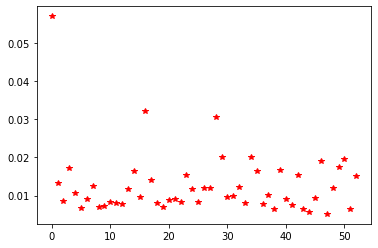

In [13]:
plt.plot(Norm_delta.T,'r*')
plt.title('Norm deltas for range of latent dimension')
plt.savefig('Results/Norm_delta__vs_Z')
#plt.show()

In [ ]:
plt.plot(Norm_omega.T,'k*')
plt.title('Norm omegas for range of latent dimension')
plt.savefig('Results/Norm_omega__vs_Z')